### Water Quality Mapping (turbidity, TSM , Chlorphyll) with reservior storage

* **Products used:**
[reservior meta data](https://digitaltwins.demos-only.iwmi.org/api2/chatbot/reservoir_metadata),
[reservior daily data](https://digitaltwins.demos-only.iwmi.org/api2/data_requests/reservoir_volumes?reservoir_id=301),
[water quality](https://explorer.digitalearth.africa/products/cgls_lwq300_2024_nrt)

### Background

Monitoring **water quality** is essential for effective water resource management, especially in reservoirs that support water supply systems. Understanding the relationship between **reservoir storage volumes** and **water quality** helps inform better decision-making for sustainable management.

This notebook explores the connection between **reservoir volume** and **water quality** over time. It utilizes **daily reservoir volume data** provided by **IWMI’s Digital Twin** and **monthly water quality indicators** from **Digital Earth Africa (DEA)**.

To perform the analysis, the notebook uses powerful Python libraries including **Datacube**, **GeoPandas**, **Pandas**, **Matplotlib**, and **Plotly** — enabling efficient data handling, analysis, and rich visualizations.


## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Install packages" cell.

### Install libraries

In [1]:
%matplotlib inline
import datacube
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import geopandas as gpd
from odc.geo.geom import Geometry
from deafrica_tools.plotting import display_map
from deafrica_tools.areaofinterest import define_area
from deafrica_tools.plotting import xr_animation, rgb
from pystac_client import Client
import datetime
import os
from odc.stac import stac_load
import requests
import pandas as pd

## Set some options for connecting to AWS

IWMI data is stored on S3 in Cape Town, Africa. To load the data, we must configure rasterio with the appropriate AWS S3 endpoint. This can be done with the odc.stac.configure_rio function. Documentation for this function is available at [https://odc-stac.readthedocs.io/en/latest/_api/odc.stac.configure_rio.html#odc.stac.configure_ri]

In [2]:
os.environ['AWS_S3_ENDPOINT'] = 's3.af-south-1.amazonaws.com'
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'
os.environ['AWS_DEFAULT_REGION'] = 'af-south-1'
os.environ['AWS_ACCESS_KEY_ID'] = ''
os.environ['AWS_SECRET_ACCESS_KEY'] = ''

print("AWS endpoint:", os.getenv('AWS_S3_ENDPOINT'))

AWS endpoint: s3.af-south-1.amazonaws.com


## Analysis parameters
this anaysis needs data about the location(lat,lon) and the interested time period to start the analysis. additionallly the user can change the buffer if necessary. that may help to increase ot decrease the area of interest.

In [3]:
from deafrica_tools.plotting import display_map

# Coordinates of Lake Manyara
lat = -25.44
lon = 29.33

# Buffer for the region around the lake
lat_buffer = 0.03
lon_buffer = 0.085
# Define the range
lat_range = (lat - lat_buffer, lat + lat_buffer)
lon_range = (lon - lon_buffer, lon + lon_buffer)

# Bounding box in [min_lon, min_lat, max_lon, max_lat]
bbox = [lon_range[0], lat_range[0], lon_range[1], lat_range[1]]


# Display the map with the bounding box
display_map(x=lon_range, y=lat_range)


## Download and load  Landsat 8 Surface Reflectance
This step will connect to IWMI stac API. The collections will specify the product name that is required to be downloaded. stac.load() requires the product name, crs and bounding box details. by default the crs is WGS84/EPSG:4326. If the coordinates are in a different coordinate system, the crs parameter can be changed.

In [4]:

# Define STAC API URL
url = 'https://explorer.digitalearth.africa/stac'

# Open the STAC catalog
catalog = Client.open(url)


# Define time range (adjust as needed)
start_date = "2024-09-01"
end_date = "2024-12-01"

# Set the product/collection name
collections = ['cgls_lwq100_2024_nrt']  # Landsat 8 Surface Reflectance

# Search the STAC catalog
query_1 = catalog.search(
    bbox=bbox,
    collections=collections,
    datetime=f"{start_date}/{end_date}"
)

# Fetch matching items
item = list(query_1.items())

In [5]:

# Coordinate Reference System (WGS 84)
crs = "EPSG:4326"

# Measurements you want to load from 'ls8_sr'
bands=('chla_mean','tsm_mean', 'turbidity_mean', 'trophic_state_index', 'floating_cyanobacteria')

# Load data with all parameters included
ds_df = stac_load(
    items=item,
    crs=crs,
    bands=bands,
    bbox=bbox,
    min_gooddata=0.50,
    groupby="solar_day",                # ensures same-day images grouped together
    dask_chunks={}  # adjust chunk size as needed
)

ds_df

<xarray.Dataset> Size: 3MB
Dimensions:                 (latitude: 68, longitude: 190, time: 10)
Coordinates:
  * latitude                (latitude) float64 544B -25.41 -25.41 ... -25.47
  * longitude               (longitude) float64 2kB 29.24 29.25 ... 29.41 29.41
    spatial_ref             int32 4B 4326
  * time                    (time) datetime64[ns] 80B 2024-09-01 ... 2024-12-01
Data variables:
    chla_mean               (time, latitude, longitude) float32 517kB nan ......
    tsm_mean                (time, latitude, longitude) float32 517kB nan ......
    turbidity_mean          (time, latitude, longitude) float32 517kB nan ......
    trophic_state_index     (time, latitude, longitude) float32 517kB nan ......
    floating_cyanobacteria  (time, latitude, longitude) float32 517kB nan ......

## Loading reservoir volume data and maping with the water quality data

this cell will call the api from IWMI digital twin https://digitaltwins.demos-only.iwmi.org/ and gives the time series volume data for the perticular dam/lake . the corresponding water quality parameters are extracted from DEA product "cgls_lwq100_2024_nrt" : https://explorer.digitalearth.africa/products/cgls_lwq300_2024_nrt . the visualization shows how the water quality deterirate with respec to diminishing lake volume

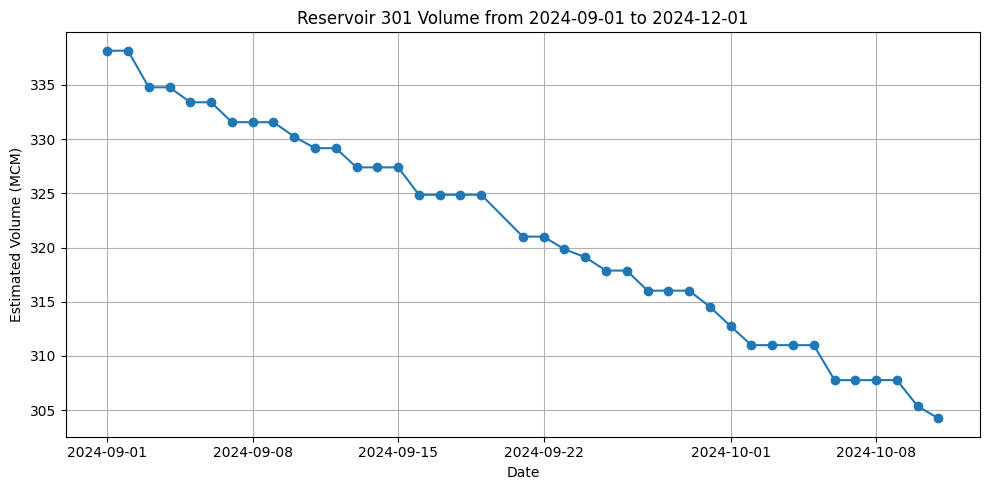

C:\Users\v.kayathri\AppData\Local\miniconda3\Lib\site-packages\xarray\groupers.py:487: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


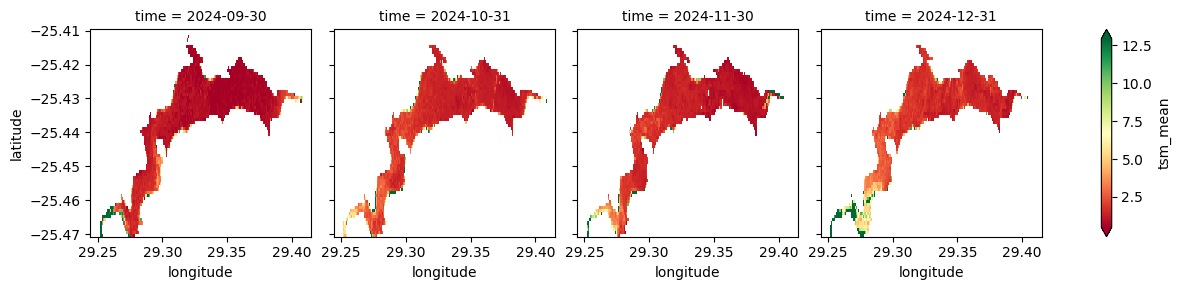

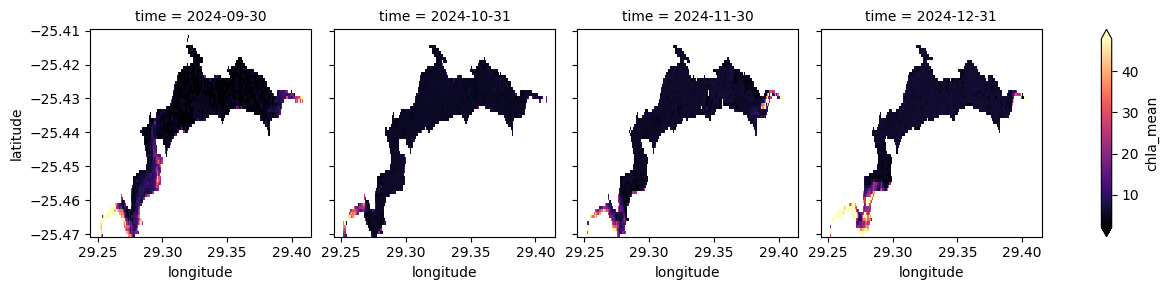

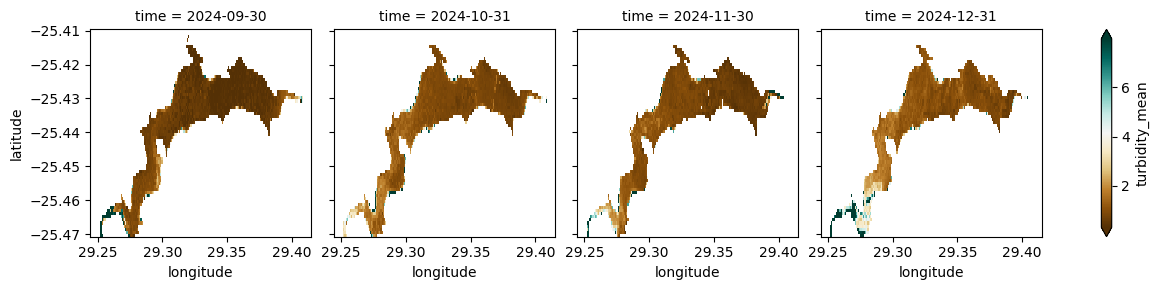

In [6]:


def fetch_reservoir_volume_timeseries(reservoir_id, start_date=None, end_date=None):
    """
    Fetch reservoir volume data and return timeseries filtered by optional date range.

    Parameters:
        reservoir_id (str or int): Reservoir identifier
        start_date (str or None): Start date in 'YYYY-MM-DD' format (inclusive). Optional.
        end_date (str or None): End date in 'YYYY-MM-DD' format (inclusive). Optional.

    Returns:
        pd.DataFrame: DataFrame with ['date', 'estimated_volume_mcm'] filtered by date range.
    """
    url = f"https://digitaltwins.demos-only.iwmi.org/api2/data_requests/reservoir_volumes?reservoir_id={reservoir_id}"
    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        df = pd.DataFrame(data)
        df['date'] = pd.to_datetime(df['date'])

        # Filter by date if requested
        if start_date:
            df = df[df['date'] >= pd.to_datetime(start_date)]
        if end_date:
            df = df[df['date'] <= pd.to_datetime(end_date)]

        return df[['date', 'estimated_volume_mcm']].reset_index(drop=True)

    except requests.RequestException as e:
        print(f"Request error: {e}")
    except ValueError as e:
        print(f"Data error: {e}")

    return None


def plot_reservoir_volume_timeseries(df, title=None):
    """
    Plot the reservoir volume time series.

    Parameters:
        df (pd.DataFrame): DataFrame with ['date', 'estimated_volume_mcm'] columns
        title (str or None): Plot title
    """
    if df is None or df.empty:
        print("No data to plot.")
        return

    plt.figure(figsize=(10, 5))
    plt.plot(df['date'], df['estimated_volume_mcm'], marker='o', linestyle='-')
    plt.xlabel('Date')
    plt.ylabel('Estimated Volume (MCM)')
    plt.title(title or 'Reservoir Estimated Volume Time Series')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Example usage:
reservoir_id = "301"
start = start_date
end = end_date

df_ts = fetch_reservoir_volume_timeseries(reservoir_id, start, end)
plot_reservoir_volume_timeseries(df_ts, title=f"Reservoir {reservoir_id} Volume from {start} to {end}")
ds_df_resampled_median = ds_df.resample(time='M').median('time')
ds_df_resampled_median['tsm_mean'].plot(col='time', cmap='RdYlGn', robust=True)
ds_df_resampled_median['chla_mean'].plot(col='time', cmap='magma', robust=True)
ds_df_resampled_median['turbidity_mean'].plot(col='time', cmap='BrBG', robust=True)

In [7]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2025-07-30'

### Reference :  

- Retief, H., Kayathri, V., Ghosh, S., Garcia Andarcia, M., & Dickens, C. (2025) ‘Satellite-Surface-Area Machine-Learning Models for Reservoir Storage Estimation: Regime-Sensitive Evaluation and Operational Deployment at Loskop Dam, South Africa’, arXiv, submitted 28 July 2025.https://doi.org/10.48550/arXiv.2502.19989
- Copernicus Land Monitoring Service. (2024). Lake Water Quality v2.0 (100 m), global, 10-daily – 2024–present. Retrieved from https://land.copernicus.eu/en/products/water-bodies/lake-water-quality-v2-0-100m



📧 **Contact:**
- Kayathri Vigneswaran 
    *[v.kayathri@cgiar.org]*  
- Surajith Gosh 
    *[s.ghosh@cgiar.org]*  